In [2]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
import numpy as np

from multilabel import MultiLabelEncoder
from pathlib import Path
from sklearn.decomposition import PCA

%matplotlib inline

In [3]:
# Graphic parameters
sns.set_style('white')

## EDA

In [4]:
data_dir = Path("data")
csv_file = Path("2016_Building_Energy_Benchmarking.csv")

df = pd.read_csv(data_dir / csv_file)
df.shape

(3376, 46)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

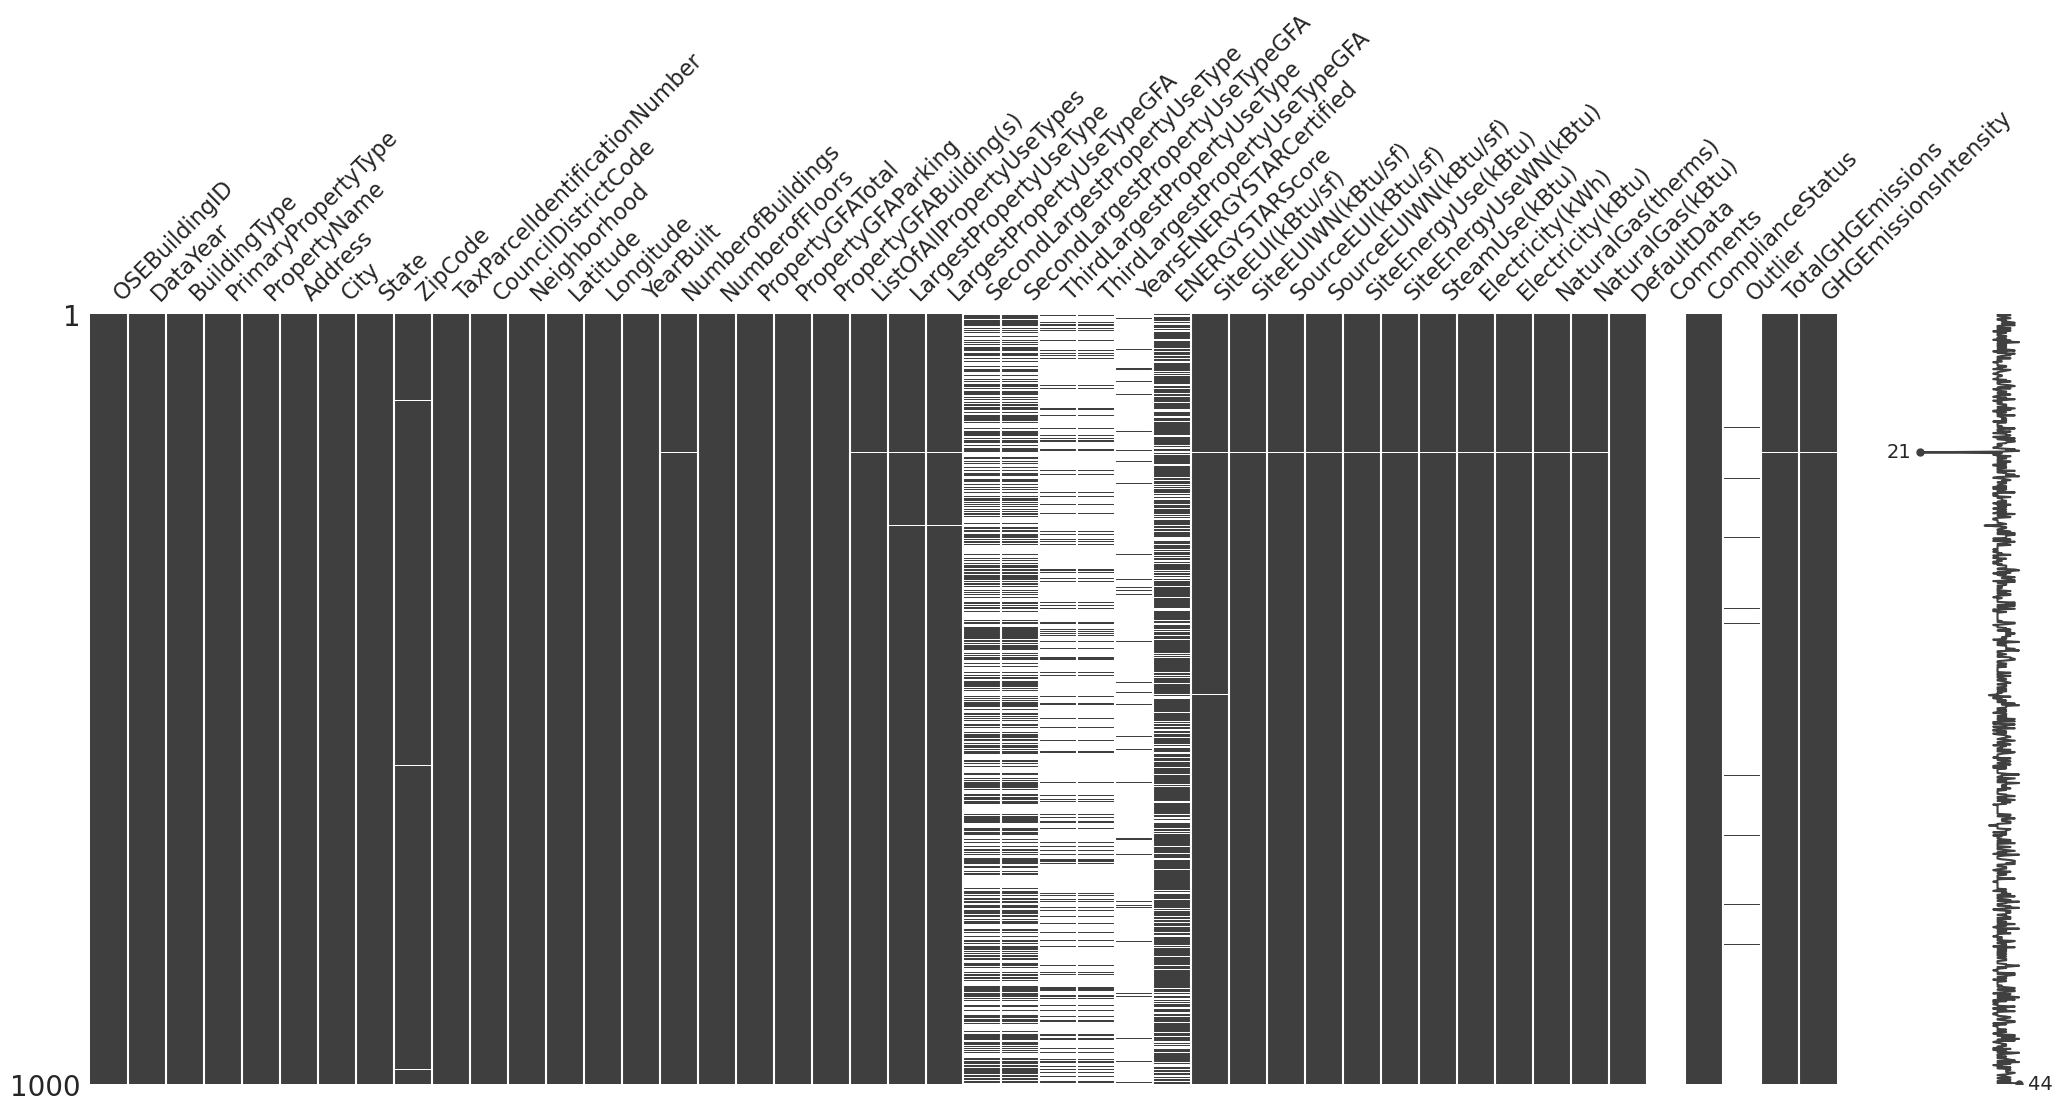

In [63]:
msno.matrix(df.sample(1000))
plt.show()

In [67]:
# Filter the dataset to keep the non-residential buildings
nr = df.query('~BuildingType.str.startswith("Multifamily")')
nr.shape

(1668, 46)

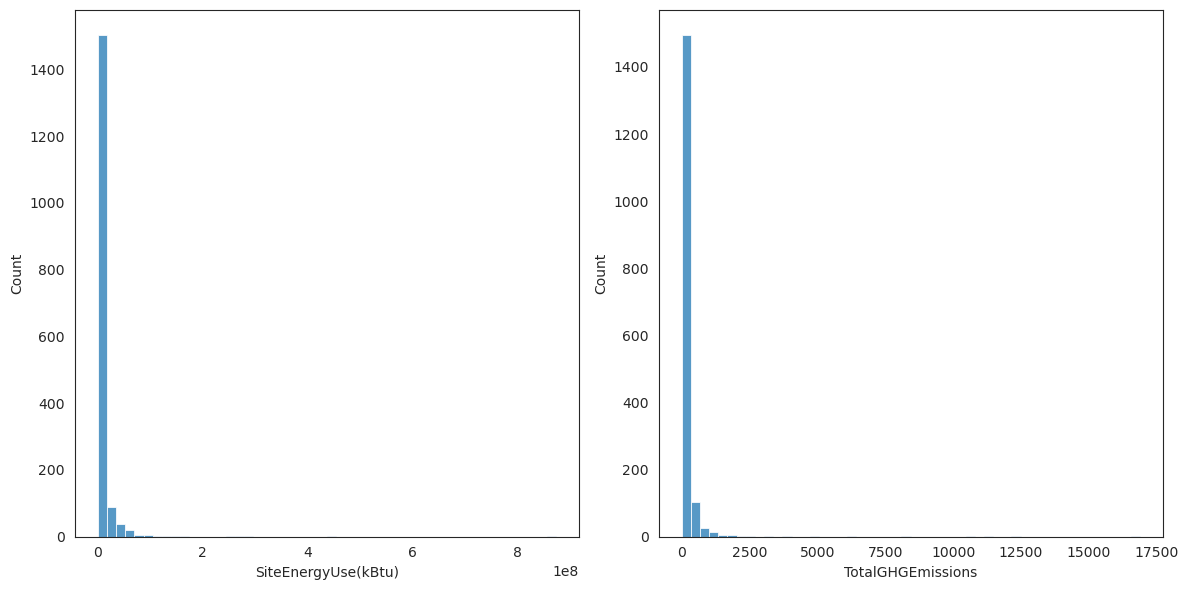

In [110]:
fig = plt.figure(figsize=(12, 6))

fig.add_subplot(121)
sns.histplot(data=nr, x='SiteEnergyUse(kBtu)', bins=50)

fig.add_subplot(122)
sns.histplot(data=nr, x='TotalGHGEmissions', bins=50)

plt.tight_layout()

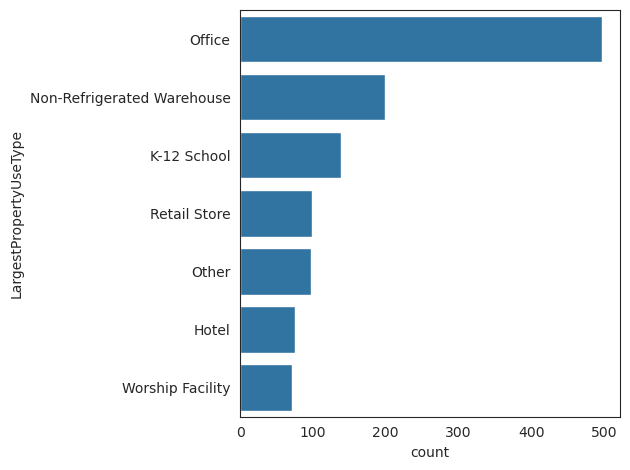

In [115]:
sns.countplot(data=nr, y='LargestPropertyUseType', order=nr['LargestPropertyUseType'].value_counts().index[:7])

plt.tight_layout()

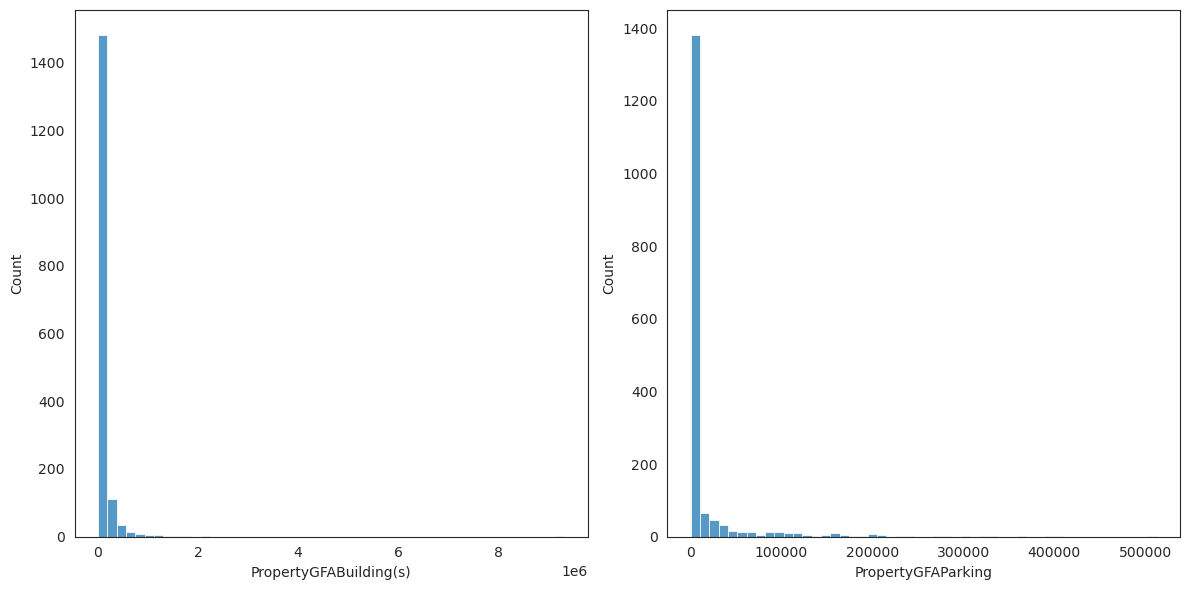

In [73]:
fig = plt.figure(figsize=(12, 6))

fig.add_subplot(121)
sns.histplot(nr['PropertyGFABuilding(s)'], bins=50)

fig.add_subplot(122)
sns.histplot(nr['PropertyGFAParking'], bins=50)

plt.tight_layout()

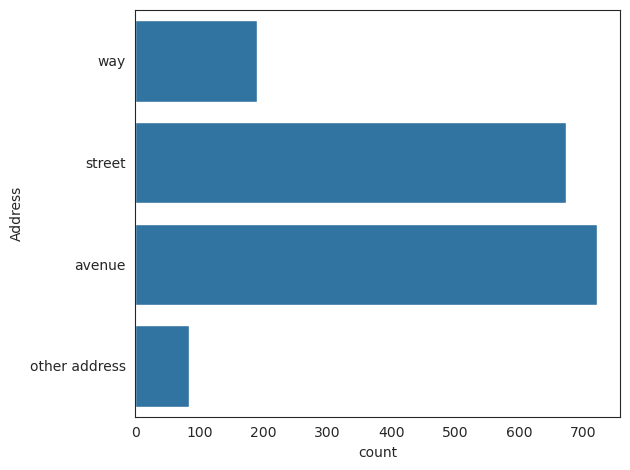

In [113]:
st_av_way = (nr['Address'].str.lower()
    .map(lambda x: 'street' if any(typ in x for typ in ['st', 'street']) else x)
    .map(lambda x: 'avenue' if any(typ in x for typ in ['av', 'ave', 'avenue']) else x)
    .map(lambda x: 'way' if 'way' in x else x)
    .map(lambda x: 'other address' if all(typ not in x for typ in ['street', 'avenue', 'way']) else x)
)

sns.countplot(st_av_way)
plt.tight_layout()

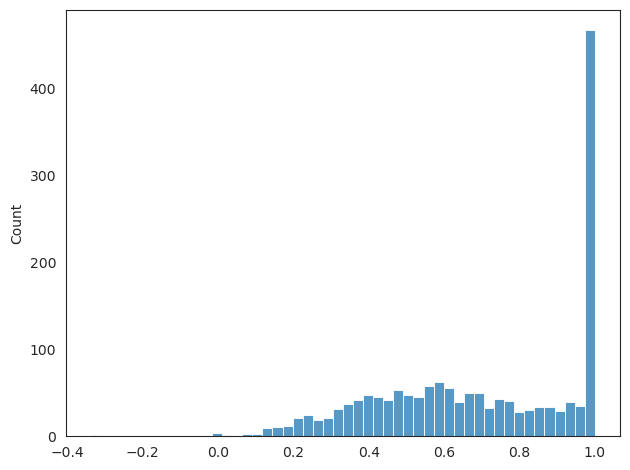

In [112]:
elec_pct = nr['Electricity(kBtu)'] / nr['SiteEnergyUse(kBtu)']
sns.histplot(elec_pct, bins=50)
plt.tight_layout()

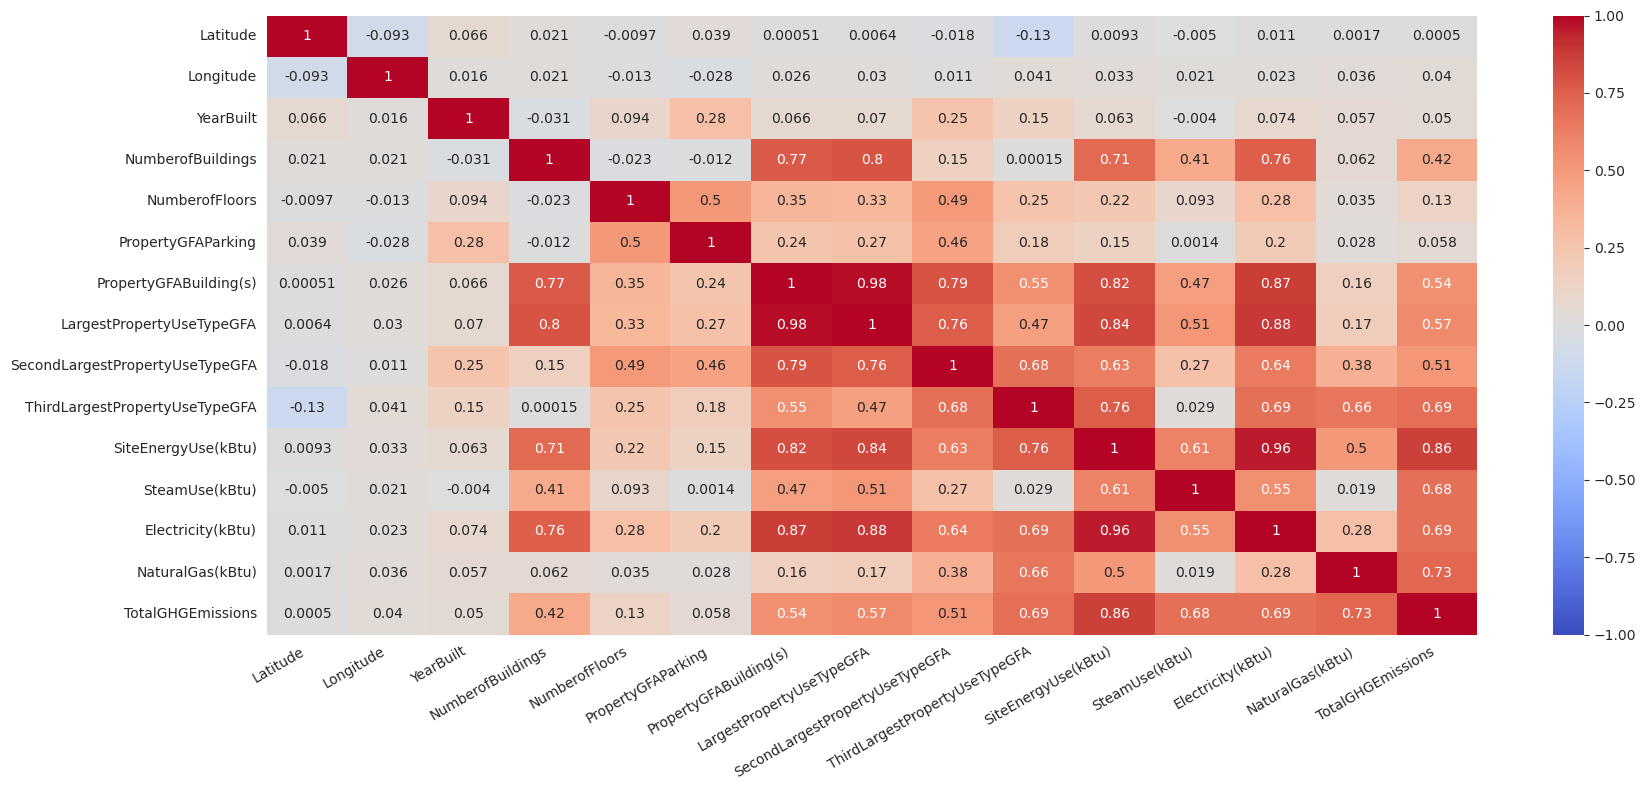

In [117]:
cm = nr[[col for col in nr.columns if nr[col].dtype.name in ['int64', 'float64']]].drop([
    'OSEBuildingID', 'DataYear', 'Comments',
    'Electricity(kWh)', 'NaturalGas(therms)', 'SiteEUIWN(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'GHGEmissionsIntensity',
    'PropertyGFATotal', 'SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)',
    'ENERGYSTARScore', 'ZipCode', 'CouncilDistrictCode'
    ], axis=1).corr()

fig, ax = plt.subplots(figsize=(18, 8))
sns.heatmap(cm, cmap="coolwarm", vmin=-1, annot=True)
labels = ax.get_label()
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
plt.tight_layout()

## Feature Engineering

In [77]:
nr

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3.946027e+06,12764.529300,1.276453e+06,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3.242851e+06,51450.816410,5.145082e+06,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,4.952666e+07,14938.000000,1.493800e+06,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2.768924e+06,18112.130860,1.811213e+06,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5.368607e+06,88039.984380,8.803998e+06,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,...,1.536550e+05,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,...,1.162210e+05,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,...,5.252517e+05,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,...,1.022480e+05,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57


### Feature Selection

In [78]:
# List of features to keep
data = nr[[
    'NumberofBuildings',
    'ListOfAllPropertyUseTypes',
    'Address',
    'PropertyGFABuilding(s)',
    'PropertyGFAParking',
    'PropertyName',
    'SecondLargestPropertyUseTypeGFA',
    'NumberofFloors',
    'Electricity(kBtu)',
    'Neighborhood',
    'YearBuilt',
    'SiteEnergyUse(kBtu)',
    'TotalGHGEmissions',
]]

# Convert the textual fields to lowercase
for col in data.columns:
    try:
        data.loc[:, col] = data[col].str.lower()
    except:
        continue

### Drop Missing Energy Consumption/GHG Emissions

In [79]:
# Drop the rows with missing values for target features
for label in ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']:
    data = data.drop(data.loc[data[label] == 0, :].index)

### OHE: Property Use Types

In [80]:
# One hot encode the top 20 property use types
mle_property_use = MultiLabelEncoder(['ListOfAllPropertyUseTypes'], rank=20, prefix='UseType')
data = mle_property_use.fit_transform(data)

### OHE: Property Name

In [87]:
# One hot encode the top 10 property names
mle_property_name = MultiLabelEncoder(['PropertyName'], rank=10, prefix='Name')
data = mle_property_name.fit_transform(data)

### OHE: Neighborhoods

In [89]:
# One hot encode the top 20 neighborhoods
mle_neighborhood = MultiLabelEncoder(['Neighborhood'], rank=10)
data = mle_neighborhood.fit_transform(data)

### Electricity Percentage

In [81]:
# Pct of electricity used out of all the energy sources used
data.loc[:, 'electricity_percentage'] = data['Electricity(kBtu)'] / data['SiteEnergyUse(kBtu)']
data = data.drop(['Electricity(kBtu)'], axis=1)

### Log GFA Buildings

In [82]:
# Log transform the building areas
data.loc[:, 'log_gfa_buildings'] = np.log1p(data['PropertyGFABuilding(s)'])
data = data.drop('PropertyGFABuilding(s)', axis=1)

### Log GFA Parking

In [83]:
# Log transform the parking areas
data.loc[:, 'log_gfa_parking'] = np.log1p(data['PropertyGFAParking'])
data = data.drop('PropertyGFAParking', axis=1)

### Log Number of Buildings

In [84]:
# Log transform the number of buildings
data.loc[:, 'log_number_of_buildings'] = np.log1p(data['NumberofBuildings'])
data = data.drop('NumberofBuildings', axis=1)

### Log Number of Floors

In [85]:
# Log transform the number of floors
data.loc[:, 'log_number_of_floors'] = np.log1p(data['NumberofFloors'])
data = data.drop('NumberofFloors', axis=1)

### Address

In [86]:
# Categorize the addresses between street, avenues, ways and others
data = pd.concat([
    data,
    pd.get_dummies(
        data['Address']
        .map(lambda x: x if any(typ in x for typ in ['av', 'st', 'way']) else 'other_address')
        .map(lambda x: 'avenue' if 'av' in x else x)
        .map(lambda x: 'street' if 'st' in x else x)
        .map(lambda x: 'way' if 'way' in x else x)
    )
], axis=1).drop('Address', axis=1)

### Impute Missing 2nd Largest Properties

In [88]:
# Set missing values to 0 for the surface of the 2nd largest property
data.loc[data['SecondLargestPropertyUseTypeGFA'].isna(), 'SecondLargestPropertyUseTypeGFA'] = 0

### Normalization

In [90]:
# Normalize all the numerical features to values between 0 and 1
for col in [c for c in data.columns if data[c].dtype.name.startswith('int') or data[c].dtype.name.startswith('float')]:
    if col not in ['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']:
        data.loc[:, col] = data[col].apply(lambda x: (x - data[col].min()) / (data[col].max() - data[col].min()))

## PCA

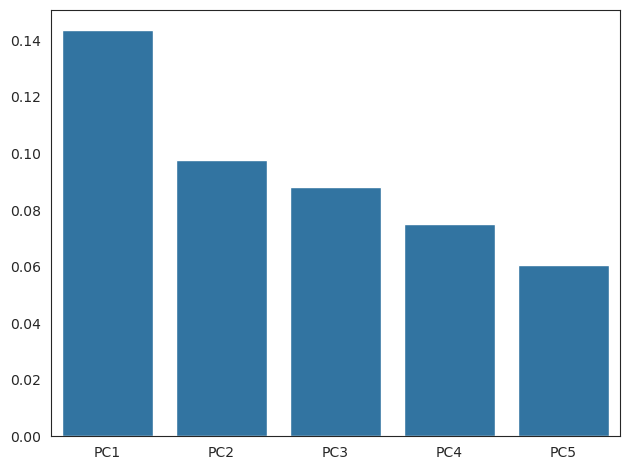

In [104]:
data_for_pca = data.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']).dropna()

# Get the 5 principal components
pca = PCA(n_components=5)
X = pca.fit_transform(data_for_pca)
cols = [f"PC{i+1}" for i in range(X.shape[1])]
components_df = pd.DataFrame(data=X, columns=cols)

# Bar plot of the explained variance ratio 
sns.barplot(x=cols, y=pca.explained_variance_ratio_)
plt.tight_layout()

In [114]:
pca1 = pd.Series(pca.components_[0], index=data_for_pca.columns).abs().sort_values(ascending=False)
pca2 = pd.Series(pca.components_[1], index=data_for_pca.columns).abs().sort_values(ascending=False)

# Show the features importance in the first two principal components
pd.concat([pca1, pca2], axis=1, keys=['PCA1', 'PCA2']).sort_values(by='PCA1', ascending=False)

,PCA1,PCA2
Neighborhood3_duwamish,0.422400,0.106935
Neighborhood5_greater,0.422400,0.106935
UseType19_warehouse,0.399255,0.106679
UseType12_refrigerated,0.399255,0.106679
UseType9_non,0.381445,0.102128
UseType11_parking,0.217572,0.208729
Neighborhood2_downtown,0.185113,0.180673
log_gfa_parking,0.163826,0.143381
UseType10_office,0.097833,0.396850
log_number_of_floors,0.087588,0.067403


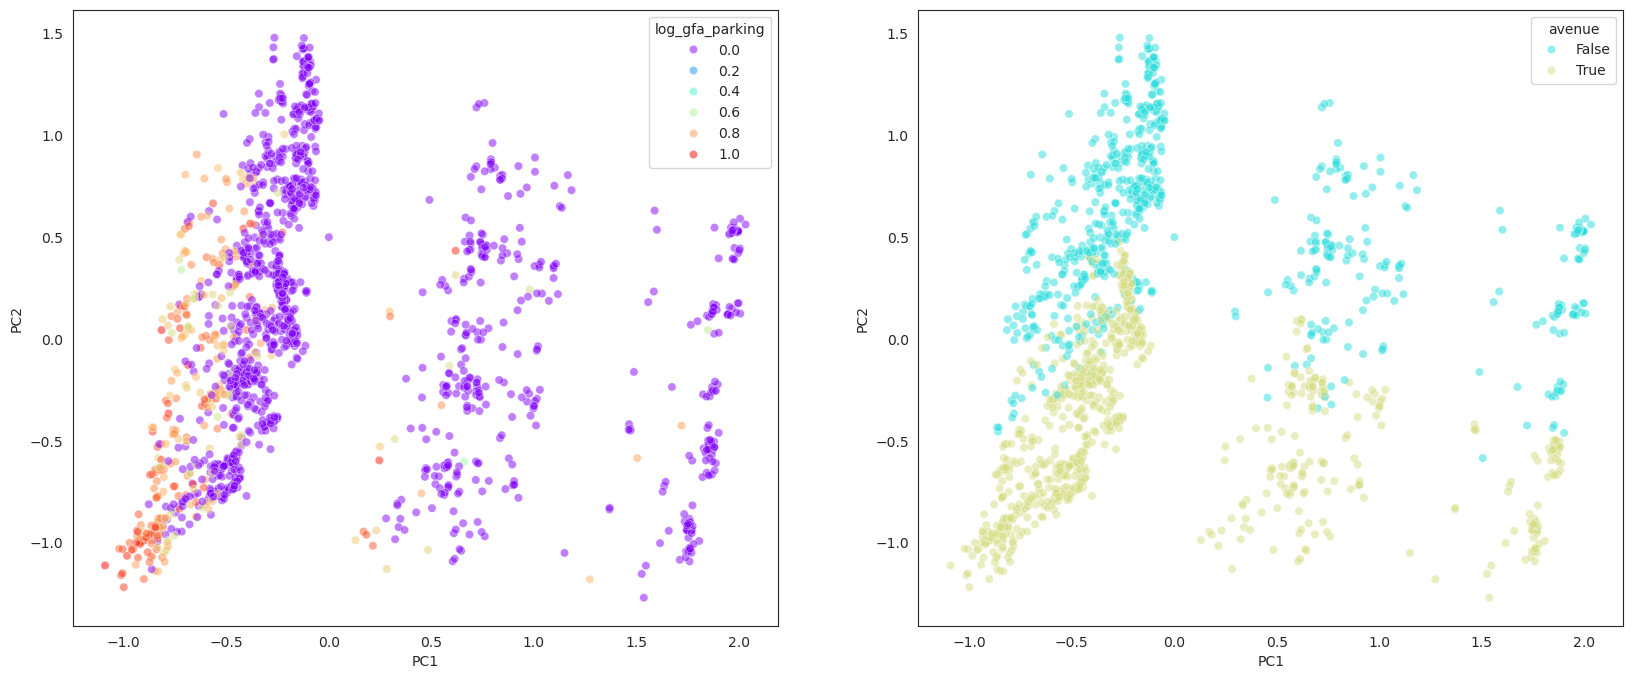

In [102]:
fig = plt.figure(figsize=(20, 8))

# Scatter plot of the data points after the PCA analysis
for i, hue in enumerate(['log_gfa_parking', 'avenue']):
    components_df[hue] = data[hue].reset_index().drop('index', axis=1)
    fig.add_subplot(1, 2, i + 1)
    sns.scatterplot(data=components_df, x='PC1', y='PC2', hue=hue, alpha=0.5, palette='rainbow')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## ENERGY STAR Score

In [48]:
# Include the ENERGY STAR Score in the dataset after normalisation
normalized_ESS = df.loc[data.index.tolist(), 'ENERGYSTARScore'].dropna()
normalized_ESS = normalized_ESS.apply(
    lambda x: (x - normalized_ESS.min()) / (normalized_ESS.max() - normalized_ESS.min())
)

data_with_energy_score = pd.concat([data, normalized_ESS], axis=1).dropna()

## Export To JSON

In [37]:
data.to_json(data_dir / 'data.json')
data_with_energy_score.to_json(data_dir / 'data_with_energy_score.json')